In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
import glob
import gc # Garbage Collector para ajudar a liberar memória

# Carregar a tabela de features v1 (resultado do notebook 02)
path_base = '../data/processed/feature_table_v1.parquet'
df_base = pd.read_parquet(path_base)
print(f"Tabela base carregada com {df_base.shape[0]} registros e {df_base.shape[1]} colunas.")

def processar_geracao_em_lotes(caminho_padrao, tamanho_lote=5):
    """
    Lê, processa e concatena dados de geração em lotes para economizar memória
    e tratar dados sujos de forma robusta.
    """
    arquivos_geracao = glob.glob(caminho_padrao)
    print(f"Encontrados {len(arquivos_geracao)} arquivos de geração para processar.")
    
    colunas_necessarias = ['din_instante', 'id_estado', 'nom_tipousina', 'val_geracao']
    tipos_de_dados = {
        'id_estado': 'category',
        'nom_tipousina': 'category',
    }
    
    lista_dfs_processados = []

    for i in range(0, len(arquivos_geracao), tamanho_lote):
        lote_arquivos = arquivos_geracao[i:i + tamanho_lote]
        print(f"\n--- Processando Lote {i//tamanho_lote + 1} ({len(lote_arquivos)} arquivos) ---")

        df_lote_raw = pd.concat([
            pd.read_csv(f, sep=';', decimal=',', usecols=colunas_necessarias, dtype=tipos_de_dados)
            for f in lote_arquivos
        ], ignore_index=True)

        df_lote_raw['val_geracao'] = pd.to_numeric(df_lote_raw['val_geracao'], errors='coerce')

        df_lote_raw.rename(columns={
            'din_instante': 'timestamp',
            'val_geracao': 'geracao_mwh'
        }, inplace=True)
        
        df_lote_raw['timestamp'] = pd.to_datetime(df_lote_raw['timestamp'])
        
        # <<< CORREÇÃO APLICADA AQUI >>>
        df_lote_raw['geracao_mwh'] = df_lote_raw['geracao_mwh'].fillna(0)
        
        df_lote_go = df_lote_raw[df_lote_raw['id_estado'] == 'GO'].copy()
        
        del df_lote_raw
        gc.collect()

        if not df_lote_go.empty:
            lista_dfs_processados.append(df_lote_go)
        else:
            print("Lote não contém dados para o estado de GO.")

    if not lista_dfs_processados:
        print("AVISO: Nenhum dado de geração para GO foi encontrado.")
        return pd.DataFrame()

    df_geracao_final = pd.concat(lista_dfs_processados, ignore_index=True)
    print("\n-> Processamento em lotes concluído com sucesso!")
    return df_geracao_final

# --- Execução (permanece igual) ---
try:
    padrao_geracao = '../data/raw/GERACAO_USINA*.csv'
    df_geracao_go = processar_geracao_em_lotes(padrao_geracao, tamanho_lote=5)
    
    if not df_geracao_go.empty:
        df_geracao_go.set_index('timestamp', inplace=True)
        print(f"-> {len(df_geracao_go)} registros de Geração para GO carregados e processados.")
    
except Exception as e:
    print(f"ERRO CRÍTICO: Falha ao processar os arquivos. Erro: {e}")
    raise

# --- Processamento Fator de Capacidade (mantido como antes) ---
print("\n--- Carregando dados de Fator de Capacidade (pulado por enquanto) ---")
fator_cap_solar_diario = pd.DataFrame()

Tabela base carregada com 5728 registros e 5 colunas.
Encontrados 46 arquivos de geração para processar.

--- Processando Lote 1 (5 arquivos) ---

--- Processando Lote 2 (5 arquivos) ---

--- Processando Lote 3 (5 arquivos) ---

--- Processando Lote 4 (5 arquivos) ---

--- Processando Lote 5 (5 arquivos) ---

--- Processando Lote 6 (5 arquivos) ---

--- Processando Lote 7 (5 arquivos) ---

--- Processando Lote 8 (5 arquivos) ---

--- Processando Lote 9 (5 arquivos) ---

--- Processando Lote 10 (1 arquivos) ---

-> Processamento em lotes concluído com sucesso!
-> 1270248 registros de Geração para GO carregados e processados.

--- Carregando dados de Fator de Capacidade (pulado por enquanto) ---


In [3]:
# --- Célula 3 (Modificada): Agregação e Criação de Features ---
print("Célula 3: Iniciando agregação dos dados de Geração pré-processados...")

if not df_geracao_go.empty:
    try:
        # 1. Feature: Geração Total Diária
        geracao_total_diaria = df_geracao_go['geracao_mwh'].resample('D').sum().to_frame(name='geracao_total_diaria_go')

        # 2. Features: Geração por Tipo de Usina
        geracao_por_tipo_diaria = (
            df_geracao_go.pivot_table(
                index=df_geracao_go.index, 
                columns='nom_tipousina', 
                values='geracao_mwh', 
                aggfunc='sum',
                observed=False  # Adicionado para manter o comportamento atual e remover o warning
            )
            .resample('D').sum()
            .fillna(0)
        )
        # Renomeia colunas para serem compatíveis com o resto do código
        geracao_por_tipo_diaria.columns = ['geracao_' + col.lower().replace(' ', '_').replace('-', '_') + '_diaria' for col in geracao_por_tipo_diaria.columns]

        print("-> Features de Geração agregadas por dia com sucesso.")
        display(geracao_total_diaria.head())
        display(geracao_por_tipo_diaria.head())

    except Exception as e:
        print(f"ERRO na Célula 3 (Agregação): {e}")
        raise
else:
    print("AVISO: DataFrame de geração está vazio. Pulando a criação de features de geração.")
    # Cria dataframes vazios para não quebrar a junção na Célula 5
    geracao_total_diaria = pd.DataFrame()
    geracao_por_tipo_diaria = pd.DataFrame()

Célula 3: Iniciando agregação dos dados de Geração pré-processados...
-> Features de Geração agregadas por dia com sucesso.


,geracao_total_diaria_go
timestamp,
2022-01-01,31569.155
2022-01-02,34196.825
2022-01-03,40238.565
2022-01-04,41981.867
2022-01-05,41837.787


,geracao_eolielétrica_diaria,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_nuclear_diaria,geracao_térmica_diaria
timestamp,,,,,
2022-01-01,0.0,0.0,30384.699,0.0,1184.456
2022-01-02,0.0,0.0,32961.224,0.0,1235.601
2022-01-03,0.0,0.0,37858.445,0.0,2380.120
2022-01-04,0.0,0.0,39270.474,0.0,2711.393
2022-01-05,0.0,0.0,39203.330,0.0,2634.457


In [4]:
# --- Processamento Robusto - Fator de Capacidade ---
print("Célula 4: Iniciando processamento dos dados de Fator de Capacidade...")
# Por enquanto, criamos um dataframe vazio para não quebrar a junção.
fator_cap_solar_diario = pd.DataFrame()
print("-> Célula 4 pulada (placeholder).")

Célula 4: Iniciando processamento dos dados de Fator de Capacidade...
-> Célula 4 pulada (placeholder).


In [5]:
# --- Junção Robusta ---
print("Célula 5: Iniciando junção dos dataframes...")

try:
    # Normaliza todos os índices antes da junção
    df_base.index = df_base.index.normalize()
    geracao_total_diaria.index = geracao_total_diaria.index.normalize()
    geracao_por_tipo_diaria.index = geracao_por_tipo_diaria.index.normalize()
    # fator_cap_solar_diario.index = fator_cap_solar_diario.index.normalize() # Desativado por enquanto

    df_combinado = df_base.copy()
    df_combinado = df_combinado.join(geracao_total_diaria)
    df_combinado = df_combinado.join(geracao_por_tipo_diaria)
    # df_combinado = df_combinado.join(fator_cap_solar_diario) # Desativado por enquanto

    df_combinado.fillna(0, inplace=True)
    
    print("-> Junção concluída com sucesso.")
    print("\n--- Diagnóstico da Tabela Combinada ---")
    df_combinado.info()
    display(df_combinado.head())

except Exception as e:
    print(f"ERRO na Célula 5: {e}")
    raise

Célula 5: Iniciando junção dos dataframes...
-> Junção concluída com sucesso.

--- Diagnóstico da Tabela Combinada ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5728 entries, 2010-01-06 to 2025-09-11
Freq: D
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   deficit_diario_mwh            5728 non-null   float64
 1   nivel_risco                   5728 non-null   object 
 2   programada                    5728 non-null   float64
 3   verificada                    5728 non-null   float64
 4   diferenca_verif_prog          5728 non-null   float64
 5   geracao_total_diaria_go       5728 non-null   float64
 6   geracao_eolielétrica_diaria   5728 non-null   float64
 7   geracao_fotovoltaica_diaria   5728 non-null   float64
 8   geracao_hidroelétrica_diaria  5728 non-null   float64
 9   geracao_nuclear_diaria        5728 non-null   float64
 10  geracao_térmica_diaria        5728 

,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_eolielétrica_diaria,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_nuclear_diaria,geracao_térmica_diaria
timestamp,,,,,,,,,,,
2010-01-06,458.4,alto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-07,4.6,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-08,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-09,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-10,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Célula 6: Gerando visualizações...


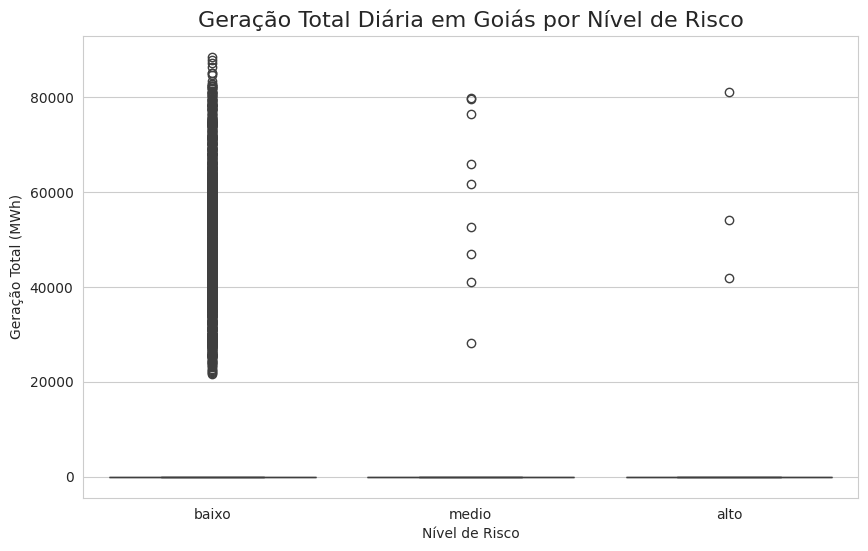

AVISO: A coluna 'fator_cap_solar_medio_seco' não foi encontrada (Célula 4 foi pulada).


In [6]:
# --- Análise Combinada (Visualizações) ---
print("Célula 6: Gerando visualizações...")

try:
    # Gráfico 1: Geração Total Diária por Nível de Risco
    # Verifica se a coluna a ser plotada realmente existe no dataframe
    if 'geracao_total_diaria_go' in df_combinado.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='nivel_risco', y='geracao_total_diaria_go', data=df_combinado, order=['baixo', 'medio', 'alto'])
        plt.title('Geração Total Diária em Goiás por Nível de Risco', fontsize=16)
        plt.ylabel('Geração Total (MWh)')
        plt.xlabel('Nível de Risco')
        plt.show()
    else:
        print("AVISO: A coluna 'geracao_total_diaria_go' não foi encontrada para plotagem.")

    # Gráfico 2: Fator de Capacidade Solar por Nível de Risco
    # A Célula 4 foi pulada, então esta coluna não existirá. O código está aqui para quando ativarmos.
    if 'fator_cap_solar_medio_seco' in df_combinado.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='nivel_risco', y='fator_cap_solar_medio_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
        plt.title('Fator de Capacidade Solar Médio (SE/CO) por Nível de Risco', fontsize=16)
        plt.ylabel('Fator de Capacidade Médio')
        plt.xlabel('Nível de Risco')
        plt.show()
    else:
        print("AVISO: A coluna 'fator_cap_solar_medio_seco' não foi encontrada (Célula 4 foi pulada).")

except Exception as e:
    print(f"ERRO ao gerar gráficos: {e}")

In [7]:
# --- Salvando o Resultado Final ---
print("Célula 7: Salvando a tabela de features atualizada...")

try:
    # Define e cria o diretório de saída se não existir
    output_path = '../data/processed/feature_table_v2.parquet'
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    # Salva a nova tabela combinada
    df_combinado.to_parquet(output_path)

    print(f"\nTabela de features V2, enriquecida com dados de geração, salva com sucesso em: {output_path}")
    print(f"Shape final da tabela: {df_combinado.shape}")

except Exception as e:
    print(f"ERRO ao salvar o arquivo: {e}")

Célula 7: Salvando a tabela de features atualizada...

Tabela de features V2, enriquecida com dados de geração, salva com sucesso em: ../data/processed/feature_table_v2.parquet
Shape final da tabela: (5728, 11)
